<a href="https://colab.research.google.com/github/svetlanama/Data-Science-in-Finance-/blob/main/Copy_of_DSIF8_0_Unsupervised_learning_in_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction



## Agenda:
**1. Outlier detection**  
**2. Clustering**  
**3. Principal Component Analysis**  
**4. Assignment**  
**5. Bonus content - NLP and sentiment analysis**  


Demo: Implementation in Python
------------------------------

### LendingClub Use Case


---


### Set up

#### User-specified parameters

In [ ]:
python_material_folder_name = "python-material-INSTRUCTOR"

#### Import libraries

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

#### Import data

In [ ]:
# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/2-intermediate/df_out_dsif6.csv").sample(1000)
df.head()

# 1 - Outlier detection

Do you remember where we saw these in previous lessons? and what methodology we used?

## 1.1 - Z scores

In [ ]:
from scipy import stats

# Calculate the Z-score for a specific column (e.g., annual_inc)
df['annual_inc_zscore'] = np.abs(stats.zscore(df['annual_inc']))

# Flag outliers (Z-score > 3)
outliers = df[df['annual_inc_zscore'] > 3]
print(f"Outliers detected using z-scores: {len(outliers)}")

## 1.2 - Interquantile range

In [ ]:
df_sample = df.sample(100) # for viz purposes

# Calculate IQR for annual_inc
Q1 = df['annual_inc'].quantile(0.25)
Q3 = df['annual_inc'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df_sample[(df_sample['annual_inc'] < lower_bound) | (df_sample['annual_inc'] > upper_bound)]
print(f"Outliers detected using IQR: {len(outliers_iqr)}")


In [ ]:
# Also this is the same as using a Box plot
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_sample['annual_inc'])
plt.title('Box plot of annual_inc')
plt.show()


## 1.3 - Autoencoders - (Bonus content)

Intuition: By training an autoencoder on normal data and calculating reconstruction errors on test data, we can identify outliers as those with reconstruction errors significantly higher than the threshold.

Example [here](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders).


# 2. Clustering
## 2.1 k-means clustering
popular clustering algorithm that partitions the data into `k` clusters by minimizing the variance within each cluster.

**Note:** We will be using 2 features in the example as it is much easier to visualise and get acquainted with this technique, but where clustering becomes very useful is on multi-dimentional data.

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Let's use a simplified dataset for demonstration (e.g., annual income and loan amount)
data_for_clustering = df[['annual_inc', 'loan_amnt']].dropna()


In [ ]:
# Let's use the Elbow graph to determine optimal number of clusters:
wcss = []
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

# Elbow Graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, max_clusters + 1), y=wcss, marker='o', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()

The "elbow point" on this graph indicates the optimal number of clusters, i.e. where adding more clusters doesn't significantly reduce WCSS.

Based on the above chart, the 'elbow' point seems to be at around 3 clusters.

In [ ]:
num_clusters = 3

In [ ]:
# Applying K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_for_clustering['cluster-km'] = kmeans.fit_predict(data_for_clustering)
data_for_clustering.head()

In [ ]:
# Visualize the clusters
plt.scatter(data_for_clustering['annual_inc'], data_for_clustering['loan_amnt'], c=data_for_clustering['cluster-km'], cmap='viridis')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('K-Means Clustering')
plt.show()


### Extrapolating insight from the created clusters
Extrapolating insights from the created clusters involves analyzing the characteristics of each group (and relationship between them) to uncover patterns that can drive business decisions.

By understanding the defining features of each cluster (e.g. spending habits, income levels, risk profiles etc.) you can craft a compelling business narrative that highlights how different customer segments behave and what they value.  

This can be leveraged to align business strategies with customer needs, tailor marketing campaigns, optimize product offerings, and enhance customer engagement. Ultimately, translating these insights into a coherent story enables stakeholders to grasp the significance of the data, make informed decisions, and identify new opportunities for growth and innovation.

In [ ]:
data_for_clustering.head()

In [ ]:
# Provide key Statistics by cluster
cluster_summary = data_for_clustering\
    .groupby('cluster-km').agg(['mean'])#, 'median', 'std', 'min', 'max'])
print("Key stats by cluster:")

# Set float format to display with 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

cluster_summary


In [ ]:
# Visualize cluster means for each feature
plt.figure(figsize=(12, 8))

feats=list(data_for_clustering.drop(columns = ['cluster-km',]).columns)
print(feats)

for feature in feats:
    sns.barplot(x='cluster-km', y=feature, data=data_for_clustering, estimator=np.mean, ci=None)
    plt.title(f'Mean of {feature} by Cluster')
    plt.show()

In [ ]:
sns.pairplot(data_for_clustering[['loan_amnt', 'annual_inc', 'cluster-km']]
             ,hue = 'cluster-km')
plt.show()

## 2.2 - Hierarchical clustering
Builds a hierarchy of clusters either in a bottom-up approach (agglomerative) or top-down approach (divisive).

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate the linkage matrix
linked = linkage(data_for_clustering[['annual_inc', 'loan_amnt']]
                , method='ward')

# First define the leaf label function.
def llf(id):
    if id < n:
        return str(id)
    else:
        return '[%d %d %1.2f]' % (id, count, R[n-id,3])


# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked
           ,truncate_mode="level" ,p= 7
          )
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points or Cluster Labels')
plt.ylabel('Distance (Euclidean)')
plt.xticks()
plt.show()


**What does this show?**  
The y-axis of a dendrogram represents the distance or similarity between clusters when they are merged.
We selected 'ward' method, hence distance metric used in this case is the variance increase (within-cluster) when clusters are merged.

**So what?**  
By analyzing the y-axis, which represents the distance or dissimilarity between merged clusters, you can determine the point at which clusters should stop being merged to retain meaningful groupings in your data.
By drawing an imaginatory horizontal line, we can pick the 'optimal number of clusters', i.e. when clusters start to become similar (low distance on the y-axis) to each other.



### <span style="color:BLUE"> **>>> DISCUSSION:**  </span>     
How many clusters should we opt for in this case?  

## 2.3 - DBSCAN (Bonus content)
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise.  
DBSCAN clusters data points that are close to each other based on density, with points in low-density regions considered as noise (outliers).  

**Advantages**
- Does not require specifying the number of clusters upfront
- Can find arbitrarily shaped clusters (see slides)
- Effectively identifies outliers

**Disadvantages**
- Sensitive to the choice of parameters (epsilon and min_samples) - see below!
> **eps (epsilon)**: The maximum distance between two samples for them to be considered as in the same neighborhood.  
> **min_samples**: The minimum number of samples required in a neighborhood to form a core point (a point that can s
- Expects data to be standardised or normalised

In [ ]:
from sklearn.cluster import DBSCAN

epsilon_range = range(1, 10, 2)
min_samples_range = range(1, 10, 2)

for epsilon in epsilon_range:
    for minimum_samples in min_samples_range:

        if epsilon == 0:  # DBSCAN requires epsilon > 0, so skip this
            continue

        # Apply DBSCAN with the current pair of parameters
        dbscan = DBSCAN(eps=epsilon, min_samples=minimum_samples)
        data_for_clustering['cluster-dbscan'] = dbscan.fit_predict(data_for_clustering[['annual_inc', 'loan_amnt']])

        # Count and print the number of clusters (excluding noise labeled as -1)
        n_clusters = len(set(data_for_clustering['cluster-dbscan']) - {-1})
        print(f"eps={epsilon}, min_samples={minimum_samples}: Number of clusters identified = {n_clusters}")


To determine a good starting value for the eps parameter in DBSCAN, you can use a K-nearest neighbors (KNN) distance plot. This plot helps you visualize the distance to the nearest neighbors and identify a suitable eps value where the slope of the curve changes significantly (often called the "elbow point").

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Select relevant features for clustering
X = data_for_clustering[['annual_inc', 'loan_amnt']].values

# Fit Nearest Neighbors model to the data (for k = 4 because DBSCAN typically considers 4 nearest neighbors)
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X)

# Calculate distances and sort them
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, 3])  # Sort distances to the 4th nearest neighbor

# Plot KNN distance plot
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title('KNN Distance Plot')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.show()

In [ ]:
epsilon = 950
min_samples_range = range(1, 10, 1)

for minimum_samples in min_samples_range:

    # Apply DBSCAN with the current pair of parameters
    dbscan = DBSCAN(eps=epsilon, min_samples=minimum_samples)
    data_for_clustering['cluster-dbscan'] = dbscan.fit_predict(data_for_clustering[['annual_inc', 'loan_amnt']])

    # Count and print the number of clusters (excluding noise labeled as -1)
    n_clusters = len(set(data_for_clustering['cluster-dbscan']) - {-1})
    print(f"eps={epsilon}, min_samples={minimum_samples}: Number of clusters identified = {n_clusters}")


In [ ]:
chosen_min_samples = 8
dbscan = DBSCAN(eps=epsilon, min_samples=chosen_min_samples)
data_for_clustering['cluster-dbscan'] = dbscan.fit_predict(data_for_clustering)
print(f"Number of clusters: {len(data_for_clustering['cluster-dbscan'].unique())-1}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define unique cluster labels
unique_labels = data_for_clustering['cluster-dbscan'].unique()

# Create a color map for categorical clusters
colors = sns.color_palette('plasma', len(unique_labels))
# # Manually specify distinct colors for each cluster
# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']  # Add more if needed

# Create a dictionary to map cluster labels to colors
color_map = dict(zip(unique_labels, colors))

# Create scatter plot with categorical colors
plt.figure(figsize=(10, 6))
for label in unique_labels:
    plt.scatter(data_for_clustering[data_for_clustering['cluster-dbscan'] == label]['annual_inc'],
                data_for_clustering[data_for_clustering['cluster-dbscan'] == label]['loan_amnt'],
                color=color_map[label],
                label=f'Cluster {label}')

# Add labels and title
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.title('DBSCAN Clustering: Annual Income vs Loan Amount')

# Add legend for categorical clusters
plt.legend(title='Clusters')
plt.show()

If your DBSCAN is identifying a large number of outliers and very few clusters, it typically means that the eps parameter is too small or the min_samples parameter is too large.

Few things you can do to adjust:  
- Increase epsilon and decrease min_sample params  
- Check data scaling: make sure the data has been standardized or normalized  


# 3 - Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a technique for dimensionality reduction and feature extraction that can be used to simplify complex datasets, identify patterns, and improve model performance.


## 3.1 - Applications

PCA is often used to:
- reduce dimensionality in the data - in particular the **curse of dimensionality** refers to challenges that highly-dimensional data leads to, such as overfitting, increased computational cost, and difficulty in visualisation/interpretability. Principal Component Analysis (PCA) is a technique that helps mitigate these problems by reducing the number of dimensions while retaining most of the variability in the data.
- for segmentation purposes: PCA can be helpful to visualise segments, having reduced multi dimensional data into lower dimensional space (e.g. 2 PCs).


## 3.2 - How does it work?

PCA is a linear transformation technique that projects data into a new coordinate system. The new coordinates, called **principal components**, are ordered by the amount of variance they capture from the data. We say that the new features that are **linear combinations** of the original features.

**Steps followed:**
1. **Standardize the Data:** Center the data around the mean and scale it to unit variance.
2. **Compute the Covariance Matrix:** Measure the covariance between features.
3. **Calculate Eigenvalues and Eigenvectors:** Determine the principal components.
4. **Sort and Select Principal Components:** Choose components that capture the most variance.
5. **Transform the Data:** Project data onto the selected principal components.

More details [here](https://en.wikipedia.org/wiki/Principal_component_analysis).


## 3.3. Python implementation

In this section, we will see a very common workflow consisting of:
- Running PCA
- Then running analysis on top of PCA outputs, more specifically:
    - Outlier detection
    - Segmentation

### 3.3.1 - PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
df.head()

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
len(df_scaled), len(df_scaled[0])

In [ ]:
# Initialize PCA with the number of components you want to keep
pca = PCA(n_components=2)  # Reduce to 2 dimensions, often used for visualization
df_pca = pd.DataFrame(pca.fit_transform(df_scaled)
                      , columns = ["pc1", "pc2"])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio by component:", explained_variance)

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative explained variance:", cumulative_variance)


**Explained Variance Ratio** indicates the proportion of the dataset's total variance that is captured by each principal component.  
**Cumulative Explained Variance** is the sum of the explained variance ratios up to a given principal component, i.e. total proportion of the variance explained by the first *'X'* principal components.

**Caveat:** 23% not good enough to use these principal components alone, we would need to add a few more to get to 80%+ (rule of thumb) to use PCs instead of original data. Sticking to 2 here for explainability purposes.  

In [ ]:
# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(df_pca["pc1"], df_pca["pc2"], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - 2D Projection of the Data')
plt.show()



PCA can be useful in conjunction with clustering techniques as a visualisation tool.

By projecting high-dimensional data into a 2D or 3D space, PCA allows the different clusters identified to be visualized in a way that is easy to interpret. This helps in validating whether the clusters are well-separated or overlapping, providing a clearer understanding of the underlying data structure.

From a business perspective, this visualization aids in making data-driven decisions. For instance, if a company segments its customers into different clusters based on purchasing behavior, PCA can help visualize these segments, revealing insights about customer groups that might not be immediately obvious. This can lead to more targeted marketing strategies, better customer service, and optimized product offerings tailored to the specific needs of different customer segments, ultimately driving higher customer satisfaction and business performance.

In [ ]:
df_pca.head()

### 3.3.2 - Outlier detection on top of PCs

In [ ]:
from scipy import stats

for col in ["pc1", "pc2"]:

    print(f"### Column: {col} ###")
    # Calculate the Z-score for a specific column (e.g., annual_inc)
    df_pca[f"{col}_zscore"] = np.abs(stats.zscore(df_pca[f"{col}"]))

    # Flag outliers (Z-score > 3)
    outliers = df_pca[df_pca[f"{col}_zscore"] > 3]
    print(f"Outliers detected using z-scores: {len(outliers)}")

In [ ]:
df_pca.head()

### 3.3.3 - Clustering on top of PCs

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Applying K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca['cluster-km'] = kmeans.fit_predict(df_pca)
df_pca.head()

In [ ]:
# Visualize the clusters
plt.scatter(df_pca['pc1'], df_pca['pc2'], c=df_pca['cluster-km'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.show()


In [ ]:
df_pca.head()

In [ ]:
df.head()

In [ ]:
df_pca.index = df.index
df_pca.head()

In [ ]:
df_merged = pd.merge(df_pca[["pc1", "pc2", "cluster-km"]]
                     , df
                     , how = "inner"
                    , left_index=True
                    , right_index=True)
df_merged.head()

In [ ]:
# Provide key Statistics by cluster
pca_cluster_summary = df_merged \
    .groupby(["cluster-km"]) \
    .agg(['median'])#, 'median', 'std', 'min', 'max'])
print("Key stats by cluster:")

# Set float format to display with 2 decimal places
pd.options.display.float_format = '{:.2f}'.format

pca_cluster_summary


4\. Assignment: Create a customer segmentation
----------------------------------------------------

### Objective

The goal of this assignment is to segment a credit card customer base into different groups for marketing and customer management purposes.

### Dataset

Use the following dataset available on Kaggle:
1. Title – Customer Credit Card Data
2. Author  - n.a., Fatemeh Habibimoghaddam (Owner)
3. Source – https://www.kaggle.com/datasets/fhabibimoghaddam/customer-credit-card-data   
(alternatively, can be found in `DSIF-course-material/python-material/data/1-raw/dsif8-assignment`)
3. License – Attribution 4.0 International (CC BY 4.0)

### Instructions
-   **Load and Explore the Data:** Start by loading the data and performing basic exploratory data analysis (EDA).
-   **Data Preprocessing:** Handle missing values, standardize the data, and prepare it for clustering.
-   **Clustering:** Apply clustering techniques like K-Means or Hierarchical Clustering to segment the customers. Optionally, use PCA to reduce dimensionality before clustering.
-   **Segmentation and interpretation:** Create meaningful and valid customer segments (at least 2, pick the number that works best for you based on your analysis) that can be leveraged for targeted marketing, customer management, and strategic decision-making.

### Submission
Submit your Python code and a brief analysis using Markdown comments summarizing your findings and insights.

### Useful references
- [Example of CACI segmentation products](https://www.caci.co.uk/datasets/fresco/): can give you some ideas of what a good segmentation may look like
- [Nationwide segmentation use case](https://www.caci.co.uk/insights/case-studies/nationwide/)
- Some more on customer segmentation: https://www.caci.co.uk/services/data-science-analytics/customer-segmentation/

# End of session

In [ ]:
from IPython.display import Image
Image(filename=f"{path_python_material}/images/the-end.jpg", width=500,)


## Home Assignment: Create a customer segmentation
segment a credit card customer base into different groups for marketing and customer management purposes.


STEP1: Load and Explore the Data: Start by loading the data and performing basic exploratory data analysis (EDA).

In [8]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

python_material_folder_name = "python-material"

try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."


df = pd.read_csv(f"drive/MyDrive/AI/PUBLIC_CSV/dsif8-assignment/Customer_Data.csv").sample(1000)

df.head()

Mounted at /content/drive


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONE_OFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONE_OFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
4280,C14398,79.345909,1.000000,906.50,0.0,906.50,0.000000,1.000000,0.0,0.916667,0.000000,0,12,6000.0,922.337660,180.755765,0.916667,12
8870,C19111,100.427621,1.000000,793.28,0.0,793.28,0.000000,1.000000,0.0,0.875000,0.000000,0,8,1000.0,679.031744,117.258435,1.000000,8
3983,C14095,1126.942655,1.000000,0.00,0.0,0.00,86.437024,0.000000,0.0,0.000000,0.166667,2,0,1200.0,353.897911,231.575224,0.000000,12
6289,C16464,2276.666051,1.000000,87.51,0.0,87.51,0.000000,0.583333,0.0,0.583333,0.000000,0,11,8000.0,605.029703,700.831872,0.000000,12
7621,C17827,5471.186593,0.777778,0.00,0.0,0.00,8411.998221,0.000000,0.0,0.000000,0.555556,10,0,9000.0,1281.454609,1401.967646,0.000000,9


### # 1 - Outlier detection
## 1.1 - Z scores

In [12]:
from scipy import stats
import numpy as np

# Calculate the Z-score for column balance
df['z_balance'] = np.abs(stats.zscore(df['BALANCE']))

df.head()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONE_OFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONE_OFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,z_balance
4280,C14398,79.345909,1.000000,906.50,0.0,906.50,0.000000,1.000000,0.0,0.916667,0.000000,0,12,6000.0,922.337660,180.755765,0.916667,12,0.695875
8870,C19111,100.427621,1.000000,793.28,0.0,793.28,0.000000,1.000000,0.0,0.875000,0.000000,0,8,1000.0,679.031744,117.258435,1.000000,8,0.686456
3983,C14095,1126.942655,1.000000,0.00,0.0,0.00,86.437024,0.000000,0.0,0.000000,0.166667,2,0,1200.0,353.897911,231.575224,0.000000,12,0.227837
6289,C16464,2276.666051,1.000000,87.51,0.0,87.51,0.000000,0.583333,0.0,0.583333,0.000000,0,11,8000.0,605.029703,700.831872,0.000000,12,0.285829
7621,C17827,5471.186593,0.777778,0.00,0.0,0.00,8411.998221,0.000000,0.0,0.000000,0.555556,10,0,9000.0,1281.454609,1401.967646,0.000000,9,1.713056


In [17]:
# Flag outliers (Z-score > 2)

# I pick up 2 as a threashold, not sure if it is ok,but, for now, seI thinkems this is an optimal
outliers = df[df['z_balance'] > 2]
print(f"Outliers detected using z-scores: {len(outliers)}")

Outliers detected using z-scores: 51


### 1.2 - Interquantile range

In [24]:
df_sample = df.sample(100)

# Calculate IQR for annual_inc
Q1 = df['BALANCE'].quantile(0.25)
Q3 = df['BALANCE'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")

# Identify outliers
outliers_iqr = df_sample[(df_sample['BALANCE'] < lower_bound) | (df_sample['BALANCE'] > upper_bound)]
print(f"Outliers detected using IQR: {len(outliers_iqr)}")

lower_bound: -2790.9554228750003
upper_bound: 4995.971550125
Outliers detected using IQR: 13


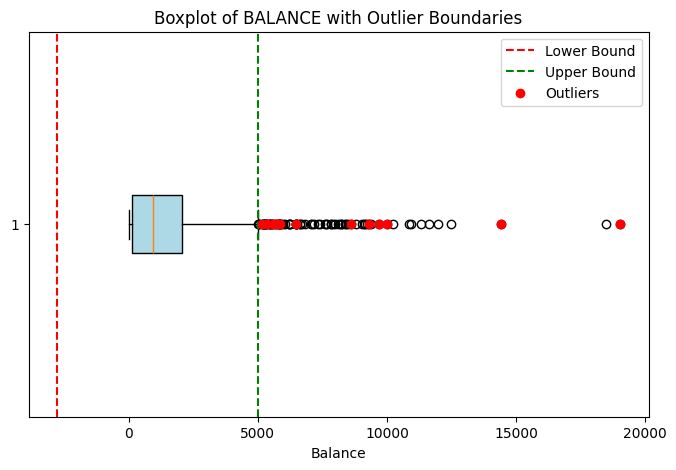

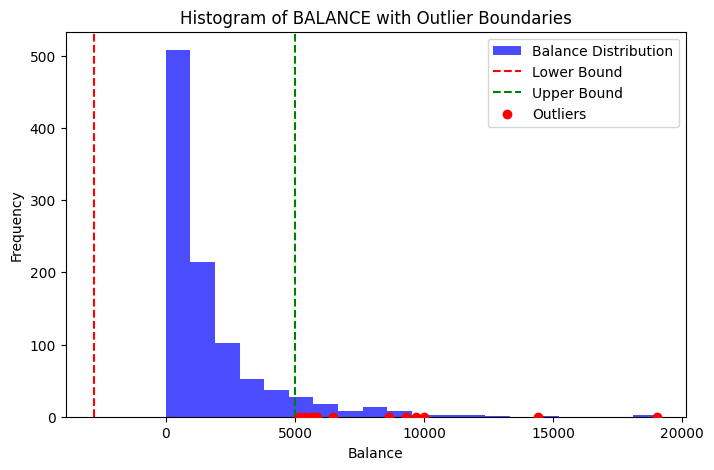

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Also this is the same as using a Box plot
import matplotlib.pyplot as plt
import seaborn as sns


# Boxplot for BALANCE to visualize outliers
plt.figure(figsize=(8, 5))
plt.boxplot(df['BALANCE'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.axvline(lower_bound, color='r', linestyle='dashed', label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='dashed', label='Upper Bound')
plt.scatter(outliers_iqr['BALANCE'], [1] * len(outliers_iqr), color='red', label='Outliers', zorder=3)
plt.xlabel("Balance")
plt.title("Boxplot of BALANCE with Outlier Boundaries")
plt.legend()
plt.show()

# Histogram to visualize the distribution of BALANCE with outliers marked
plt.figure(figsize=(8, 5))
plt.hist(df['BALANCE'], bins=20, alpha=0.7, color='blue', label="Balance Distribution")
plt.axvline(lower_bound, color='r', linestyle='dashed', label='Lower Bound')
plt.axvline(upper_bound, color='g', linestyle='dashed', label='Upper Bound')
plt.scatter(outliers_iqr['BALANCE'], [0] * len(outliers_iqr), color='red', label='Outliers', zorder=3)
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.title("Histogram of BALANCE with Outlier Boundaries")
plt.legend()
plt.show()

According to diagram we can cut outliners after 5000

### 2. Clustering

In [25]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


data_for_clustering = df[['BALANCE', 'PURCHASES']].dropna()

In [27]:
# Use the Elbow graph to determine optimal number of clusters:
wcss = []
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(data_for_clustering)
    wcss.append(kmeans.inertia_)

# Elbow Graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, max_clusters + 1), y=wcss, marker='o', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>